In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
from collections import Counter
from tqdm import tqdm
import spateo as st
import seaborn as sns
import pandas as pd
import scanpy as sc
from scipy import spatial

def adjusted_rand_score(y_true, y_pred):
    (tn, fp), (fn, tp) = metrics.pair_confusion_matrix(y_true, y_pred)
    tn, tp, fp, fn =int(tn), int(tp), int(fp), int(fn)
    if fn == 0 and fp == 0:
        return 1.0
    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

def compute_stats(y_true, y_pred):
    y_true_bool = y_true > 0
    y_pred_bool = y_pred > 0
    pos = y_true_bool.sum()
    neg = (~y_true_bool).sum()
    
    y_true_bool_flattened = y_true_bool.flatten()
    y_pred_bool_flattened = y_pred_bool.flatten()
    tn, fp, fn, tp = metrics.confusion_matrix(y_true_bool_flattened, y_pred_bool_flattened).ravel()
    f1 = metrics.f1_score(y_true_bool_flattened, y_pred_bool_flattened)
    
    where = (y_true > 0) & (y_pred > 0)
    y_true_labels = y_true[where]
    y_pred_labels = y_pred[where]
    ars = adjusted_rand_score(y_true_labels, y_pred_labels)
    homogeneity, completeness, v = metrics.homogeneity_completeness_v_measure(y_true_labels, y_pred_labels)
    
    return tn / neg, fp / neg, fn / pos, tp / pos, f1, ars, homogeneity, completeness, v

/home/kmin/miniconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: ssiopeia-lineage is an invalid version and will not be supported in a future release
  warnings.warn(
/home/kmin/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/kmin/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometrie

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2022-03-29 13:37:26.051818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lab/solexa_weissman/kmin/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/nfs/lsf8/8.0/linux2.6-glibc2.3-x86_64/lib


## Load data

In [2]:
seg_adata = anndata.read('data/SS200000135.h5ad')
cell_adata = anndata.read('data/adata_SS200000135_cell_labels.h5ad')
X_adata = anndata.read('data/adata_SS200000135_X_labels.h5ad')
random_adata = anndata.read('data/adata_SS200000135_random_X_labels.h5ad')

## Pixel classification statistics

Consider the segmentation problem as a pixel classification problem.

### Nuclei labels

In [19]:
stain_labels = seg_adata.layers['stain_labels'][seg_adata.X.A > 0]
unspliced_labels = seg_adata.layers['unspliced_labels'][seg_adata.X.A > 0]
values = compute_stats(stain_labels, unspliced_labels)
pd.DataFrame({'value': values}, index=[
    'True negative',
    'False positive',
    'False negative',
    'True positive',
    'F1 score',
    'Adjusted rand score',
    'Homogeneity',
    'Completeness',
    'V measure'
])

,value
True negative,0.938044
False positive,0.061956
False negative,0.670561
True positive,0.329439
F1 score,0.398855
Adjusted rand score,0.892228
Homogeneity,0.979909
Completeness,0.990108
V measure,0.984982


### Cell labels

In [20]:
cell_labels = seg_adata.layers['cell_labels_expanded'][seg_adata.X.A > 0]
X_labels = seg_adata.layers['X_labels_expanded'][seg_adata.X.A > 0]
values = compute_stats(cell_labels, X_labels)
pd.DataFrame({'value': values}, index=[
    'True negative',
    'False positive',
    'False negative',
    'True positive',
    'F1 score',
    'Adjusted rand score',
    'Homogeneity',
    'Completeness',
    'V measure'
])

,value
True negative,0.944805
False positive,0.055195
False negative,0.630809
True positive,0.369191
F1 score,0.502152
Adjusted rand score,0.779811
Homogeneity,0.957866
Completeness,0.979080
V measure,0.968357


Compare these to randomly permuted labels.

In [21]:
cell_labels = seg_adata.layers['cell_labels_expanded'][seg_adata.X.A > 0]
random_labels = seg_adata.layers['random_X_labels_expanded'][seg_adata.X.A > 0]
values = compute_stats(cell_labels, random_labels)
pd.DataFrame({'value': values}, index=[
    'True negative',
    'False positive',
    'False negative',
    'True positive',
    'F1 score',
    'Adjusted rand score',
    'Homogeneity',
    'Completeness',
    'V measure'
])

,value
True negative,9.138591e-01
False positive,8.614092e-02
False negative,9.139541e-01
True positive,8.604594e-02
F1 score,1.383319e-01
Adjusted rand score,-2.222445e-07
Homogeneity,6.214157e-01
Completeness,6.620336e-01
V measure,6.410819e-01


## Cell statistics

Compare cell Anndatas.

### Genes detected

In [9]:
sc.pp.calculate_qc_metrics(cell_adata, inplace=True)
sc.pp.calculate_qc_metrics(X_adata, inplace=True)

Text(0.5, 1.0, 'X 598.0')

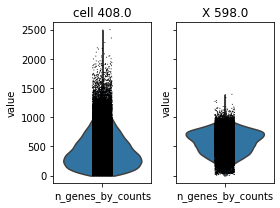

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(4, 3), tight_layout=True, sharey=True)

column = 'n_genes_by_counts'
sc.pl.violin(cell_adata, column, ax=axes[0], show=False)
axes[0].set_title(f'cell {cell_adata.obs[column].median()}')
sc.pl.violin(X_adata, column, ax=axes[1], show=False)
axes[1].set_title(f'X {X_adata.obs[column].median()}')

### Total UMIs

Text(0.5, 1.0, 'X 1517.0')

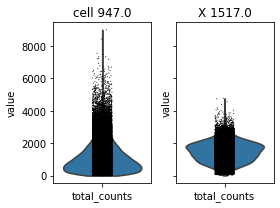

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(4, 3), tight_layout=True, sharey=True)

column = 'total_counts'
sc.pl.violin(cell_adata, column, ax=axes[0], show=False)
axes[0].set_title(f'cell {cell_adata.obs[column].median()}')
sc.pl.violin(X_adata, column, ax=axes[1], show=False)
axes[1].set_title(f'X {X_adata.obs[column].median()}')

### Cell-cell cosine distance

Cosine distance between each RNA-segmented cell and its (spatially) closest staining cell.

<AxesSubplot:xlabel='cosine_distance', ylabel='Count'>

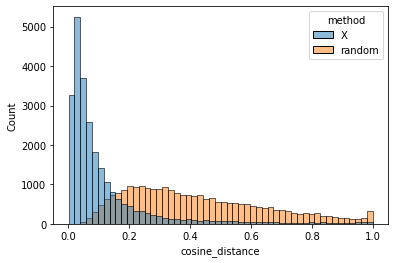

In [4]:
nearest = np.concatenate(list(metrics.pairwise_distances_chunked(X_adata.obsm['spatial'], cell_adata.obsm['spatial'], n_jobs=16, reduce_func=lambda D_chunk, start: D_chunk.argmin(axis=1), working_memory=64)))
cell = cell_adata.X.A
X = X_adata.X.A

X_distances = []
for i, j in enumerate(nearest):
    X_distances.append(spatial.distance.cosine(X[i], cell[j]))
    
random_distances = []
for i, j in enumerate(np.random.choice(cell_adata.n_obs, X_adata.n_obs, replace=False)):
    random_distances.append(spatial.distance.cosine(X[i], cell[j]))

sns.histplot(data=pd.concat((
    pd.DataFrame({'cosine_distance': X_distances, 'method': 'X'}),
    pd.DataFrame({'cosine_distance': random_distances, 'method': 'random'}),
), ignore_index=True), x='cosine_distance', hue='method')